# Aim of the notebook

In this notebook we do an initial exploration of the output generated by spots2regions, exploring the subcellular patterning of the mouse brain sections

In [415]:
# import packages and functions

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import colorsys
import random
import random
import matplotlib.colors as mcolors
from xb.formatting import generate_random_color_variation


# read files

In [2]:
reads=pd.read_csv('/media/sergio/xenium_b_and_heart/Xenium_benchmarking-main/figures/4.fast_kmeans/results/ms_brain_multisection2_spots_sigma3.0_stride1.0_clusters100-003.csv')
dist=pd.read_csv('/media/sergio/xenium_b_and_heart/Xenium_benchmarking-main/data/reads_csvs/multisection_2_reads_distance.csv')
adata=sc.read('/media/sergio/xenium_b_and_heart/Xenium_benchmarking-main/data/unprocessed_adata/ms_brain_multisection2.h5ad')

In [76]:
# read adata with nuclear info

In [63]:
saving_path=r'../../data/processed_adata/'
adata_nuc=sc.read(saving_path+'/adata_multisection_nuclei_3rep_withHM_withclusters.h5ad')
coldict=dict(zip(np.unique(adata_nuc.obs['Class']),adata_nuc.uns['Class_colors']))
coldict['Background']='#000000'

/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
reads['overlaps_nucleus']=list(adata.uns['spots']['overlaps_nucleus'])
readid_dist=dict(zip(dist['Unnamed: 0'],dist['distance']))
reads['distance']=reads.index.map(readid_dist)

In [ ]:
table=pd.crosstab(reads['points2regions'],reads['Class'])
aggregate=table.div(table.sum(axis=1),axis=0)
meanvals=reads.groupby('points2regions').mean()
distic=dict(zip(meanvals.index,meanvals['distance']))
overlapsdic=dict(zip(meanvals.index,meanvals['overlaps_nucleus']))

# Sort matrix

In [389]:
# Find the column with the maximum value for each row
max_column = aggregate.idxmax(axis=1)
# Create a new DataFrame by sorting the original DataFrame based on max_column
sorted_df = aggregate.iloc[max_column.argsort()]

coldicti=[generate_random_color_variation(base_color) for base_color in sorted_df.idxmax(axis=1).map(coldict) ]
#coldicti=[base_color for base_color in sorted_df.idxmax(axis=1).map(coldict) ]
generate_random_color_variation(base_color)


'#40caca'

In [390]:
newnam=pd.DataFrame(sorted_df.idxmax(axis=1))
newnam['nucpr']=newnam.index.map(overlapsdic)
newnam['nucpr']=np.round(newnam['nucpr'],3)
dicnuc={True:'nuclei',False:'cyto'}
newnam['newname']=[str(indi)+'_'+str(newnam.loc[indi,0])+'_'+str(dicnuc[newnam.loc[indi,'nucpr']>0.5]) for indi in newnam.index]
newnamedict=dict(zip(newnam.index,newnam['newname']))
reads['p2r_name']=reads['points2regions'].map(newnamedict)
mapping_clust=dict(zip(newnam.index,newnam[0]))
reads['closer_clust']=reads['points2regions'].map(mapping_clust)

In [416]:
# classify depending on wether it 50% of reads are in nuclei or not in cytoplasmatic vs nuclear

In [397]:
for indi in sorted_df.index:
    if overlapsdic[indi]<0.5:
        sorted_df.loc[indi,:]=-sorted_df.loc[indi,:]

In [398]:
dictiogood=dict(zip(sorted_df.index.map(newnamedict),coldicti))
reads['color']=reads['p2r_name'].map(dictiogood)
readssub=reads.loc[:,['x_location','y_location','p2r_name']]

In [413]:
reads.to_csv('/media/sergio/xenium_b_and_heart/Xenium_benchmarking-main/figures/4.fast_kmeans/results/ms_brain_multisection2_spots_sigma3.0_stride1.0_clusters100-003_allinfo.csv')

In [ ]:
sns.set(rc={'figure.figsize':(11.7,18.27)})
sns.clustermap(sorted_df,cmap='coolwarm',vmin=-1,vmax=1,row_cluster=False, col_cluster=False,figsize=(20,35),col_colors=sorted_df.columns.map(coldict),row_colors=coldicti)

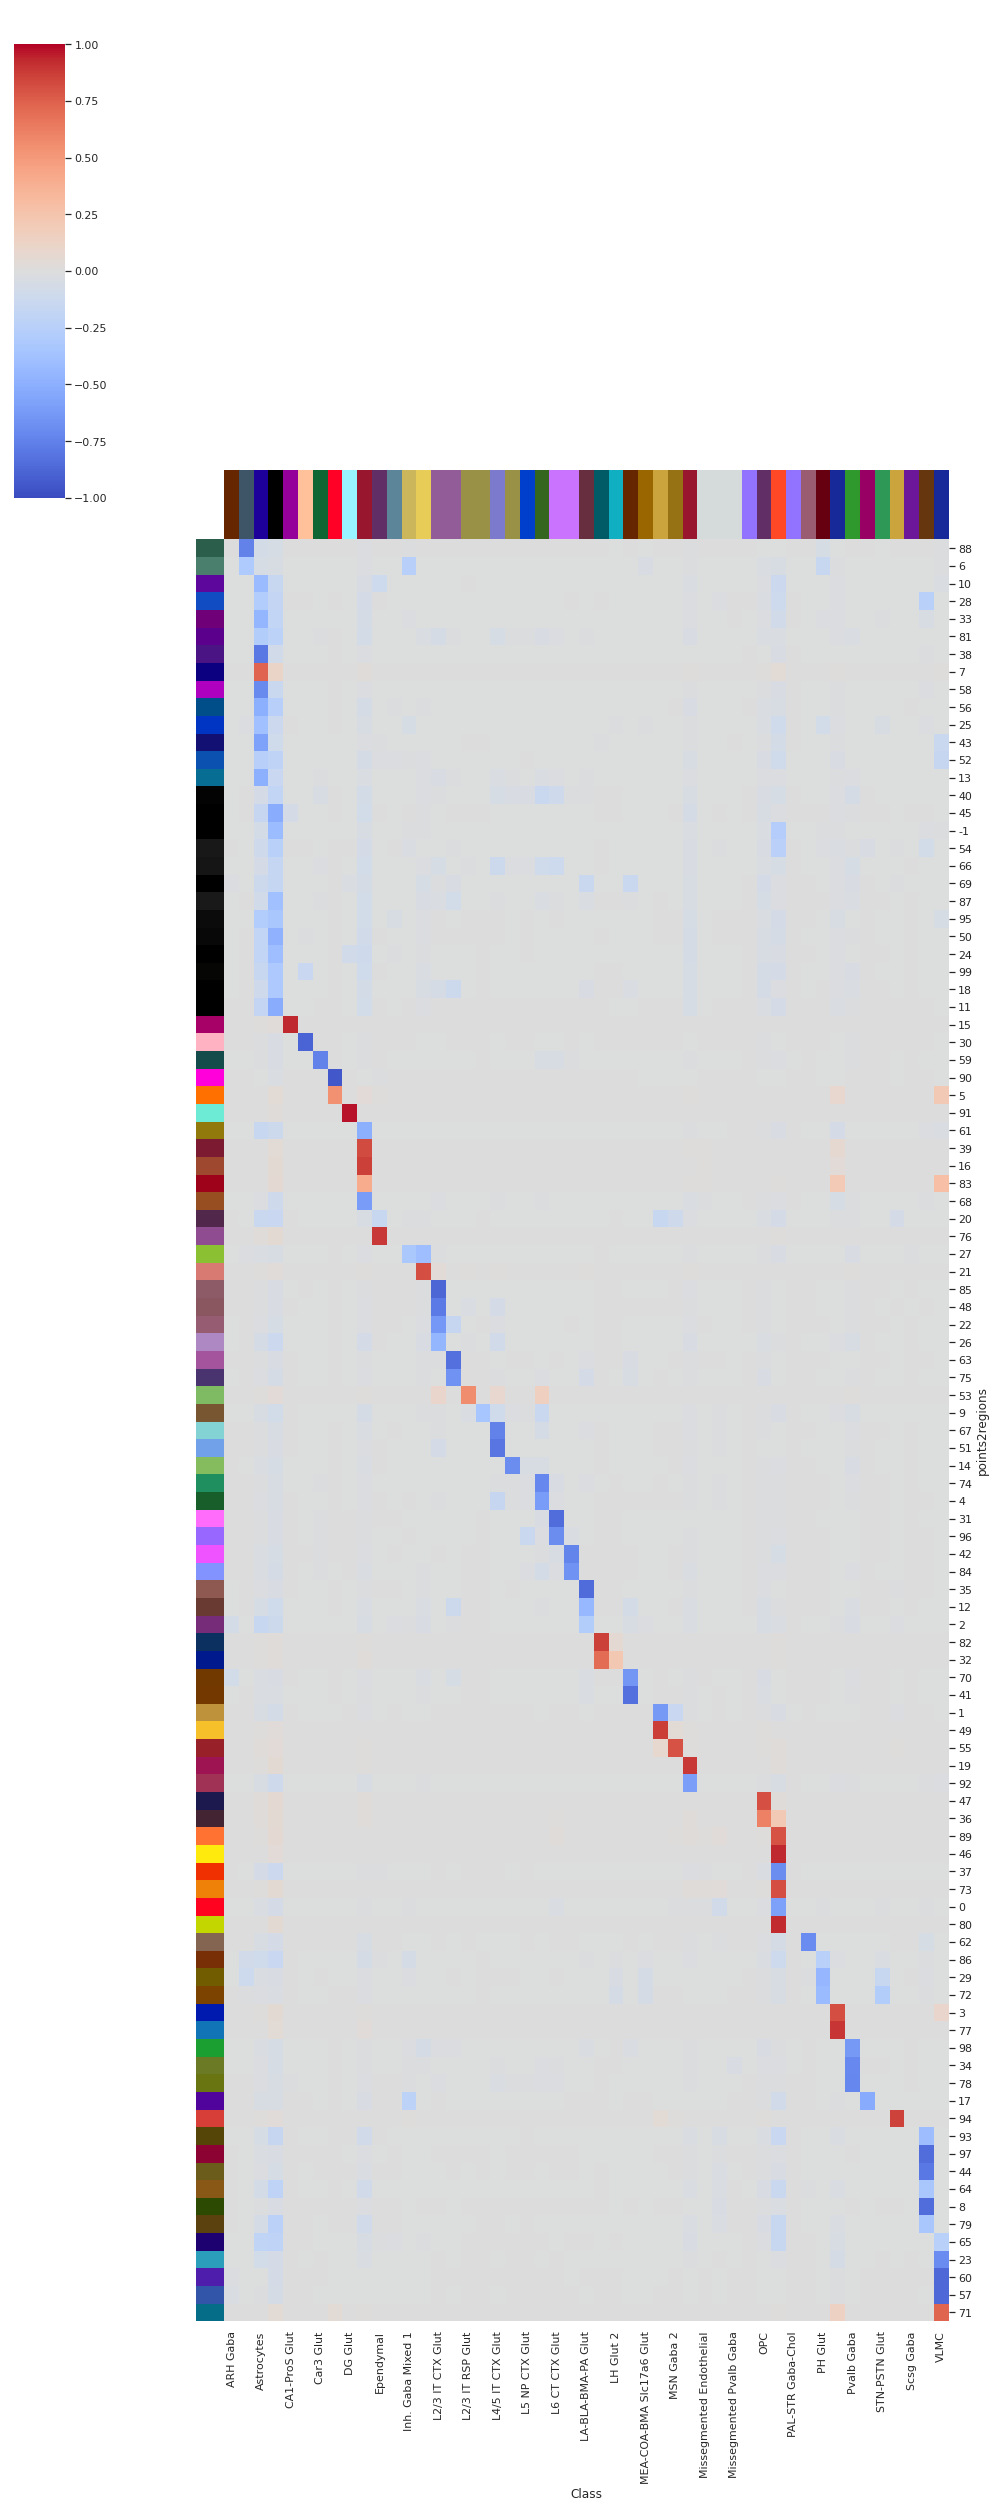

In [219]:
sns.set(rc={'figure.figsize':(11.7,18.27)})
sns.clustermap(sorted_df,cmap='coolwarm',vmin=-1,vmax=1,row_cluster=False, col_cluster=False,figsize=(14,35),col_colors=sorted_df.columns.map(coldict),row_colors=coldicti)

In [382]:
maxvals=reads.groupby('points2regions').idxmax()

/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:1309: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  keys, values, mutated = self.grouper.apply(f, data, self.axis)


# Further exploring

In [ ]:
readssub.iloc[0:1000000,:].to_csv('/media/sergio/xenium_b_and_heart/Xenium_benchmarking-main/figures/4.fast_kmeans/results/ms_brain_multisection2_spots_sigma3.0_stride1.0_clusters100-003_plotting.csv')

In [400]:
readsub=reads[reads['closer_clust']=='Oligodendrocytes']

In [401]:
readsub['p2r_name'].unique()

array(['0_Oligodendrocytes_cyto', '89_Oligodendrocytes_nuclei',
       '37_Oligodendrocytes_cyto', '46_Oligodendrocytes_nuclei',
       '73_Oligodendrocytes_nuclei', '80_Oligodendrocytes_nuclei'],
      dtype=object)

In [402]:
expression=pd.crosstab(readsub['feature_name'],readsub['p2r_name'])

In [403]:
expressionfilt=expression.loc[np.max(expression,axis=1)>1000,:]

In [404]:
expressionfilt=expressionfilt.div(expressionfilt.sum(axis=0),axis=1)

In [405]:
readsub.shape

(2395462, 11)

In [407]:
readssub=readsub.loc[:,['x_location','y_location','p2r_name','feature_name']]

In [408]:
readssub.to_csv('/media/sergio/xenium_b_and_heart/Xenium_benchmarking-main/figures/4.fast_kmeans/results/ms_brain_multisection2_spots_sigma3.0_stride1.0_clusters100-003_plotting_OLIGO.csv')

In [378]:
# Find the column with the maximum value for each row
max_column = expressionfilt.idxmax(axis=1)
# Create a new DataFrame by sorting the original DataFrame based on max_column
expressionfilt_sorted = expressionfilt.iloc[max_column.argsort()]

In [379]:
expressionfiltnorm=expressionfilt_sorted.div(expressionfilt_sorted.sum(axis=1),axis=0)

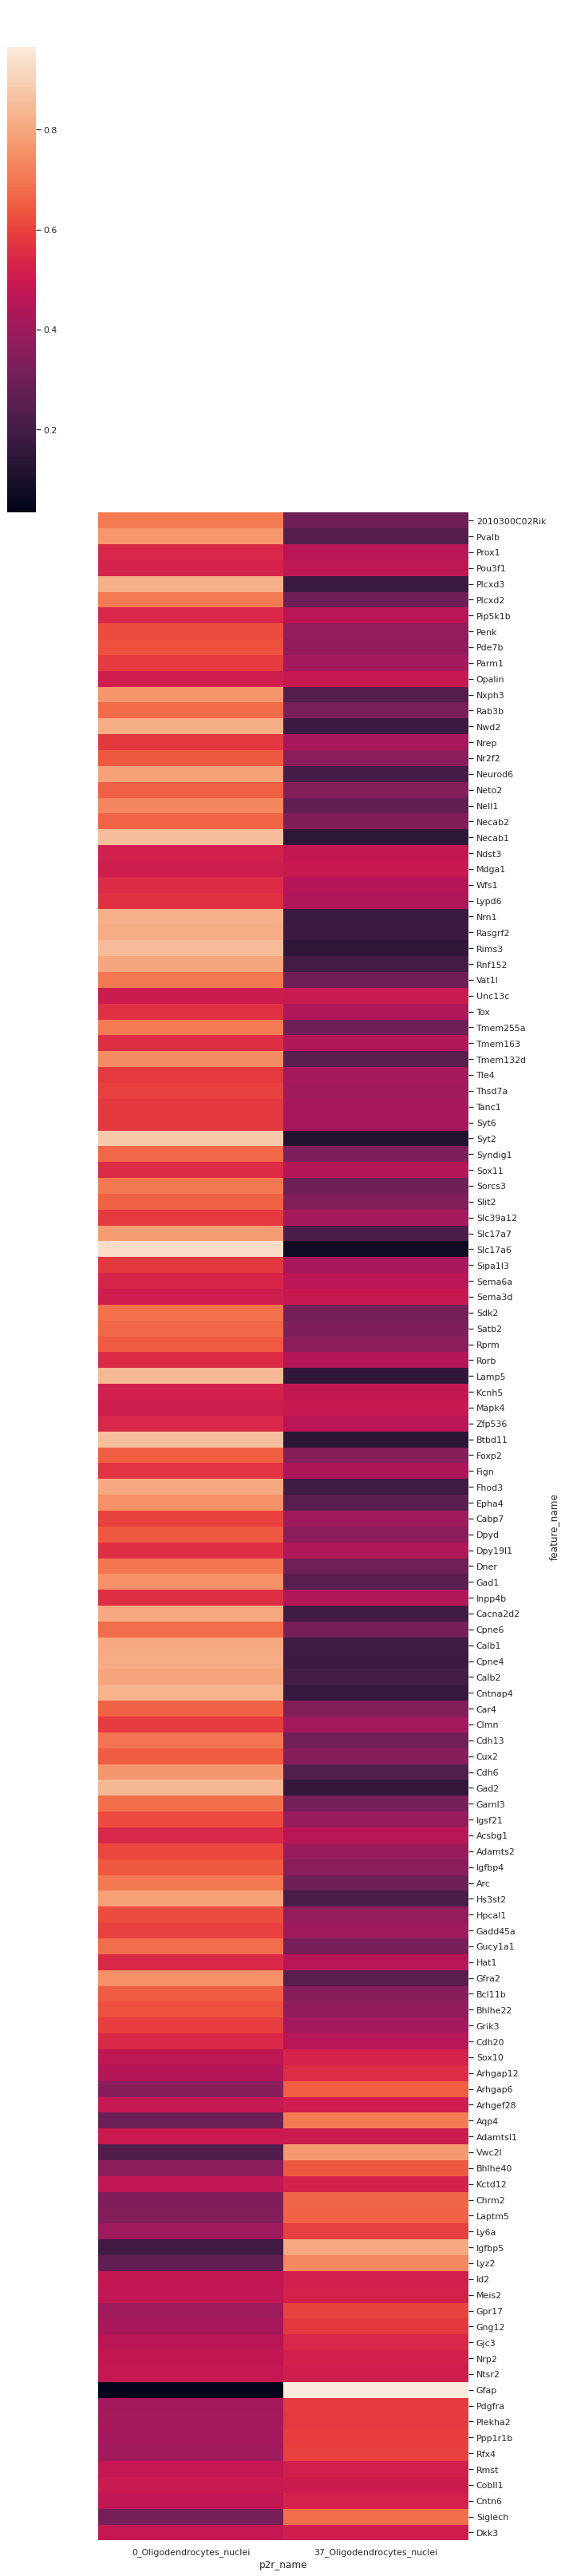

In [380]:
sns.set(rc={'figure.figsize':(11.7,30.27)})
sns.clustermap(expressionfiltnorm,row_cluster=False, col_cluster=False,figsize=(10,45))

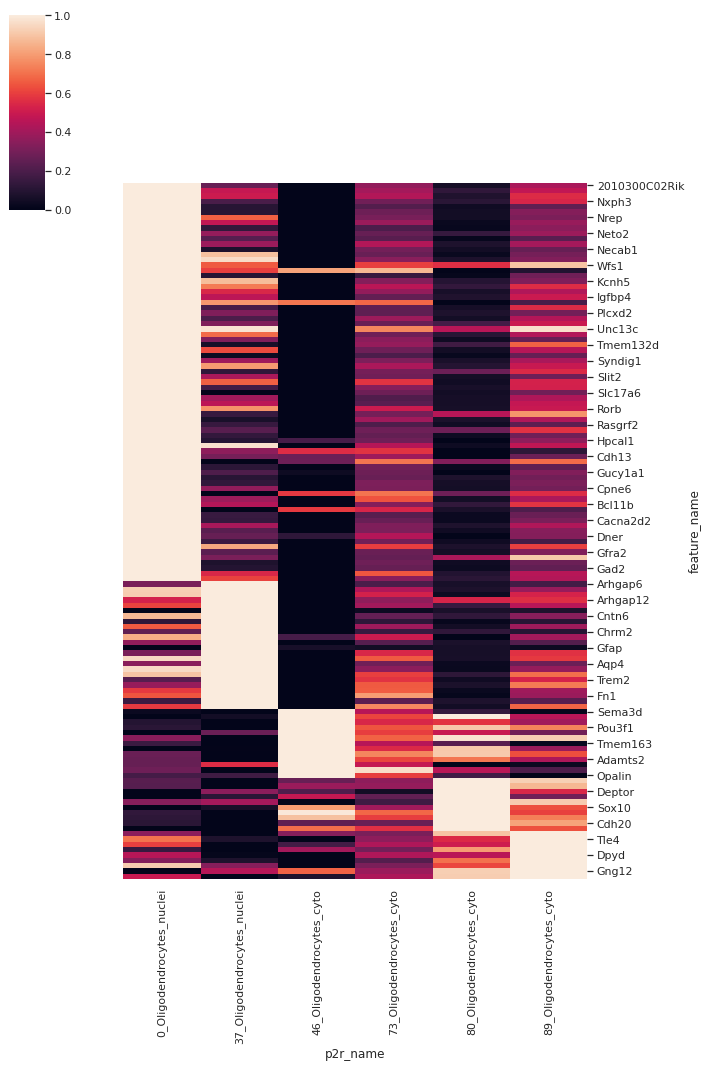

In [322]:
sns.set(rc={'figure.figsize':(11.7,30.27)})
sns.clustermap(expressionfilt_sorted,row_cluster=False, col_cluster=False,standard_scale=0,figsize=(10,15))